We will now demonstrate robust optimization with a ybranch that can be under or overetched

In [1]:
from config import Config
import os, sys
sys.path.append(Config.LUMERICAL_API_PATH) # if this fails adjust the config.py and add the lumerical api path
root_path = Config.ROOT_DIR
import numpy as np
import scipy as sp

import lumapi
from lumopt.utilities.wavelengths import Wavelengths
import lumopt.utilities.wavelengths as w1
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.utilities.materials import Material
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.geometries.geometry import Geometry
from lumopt_gl.geometries.geometry_gl import Geometry_GL
from lumopt_gl.geometries.polygon_gl import FunctionDefinedPolygon_GL
from lumopt_gl.optimization import OptimizationGL


CONFIGURATION FILE {'root': 'C:\\Program Files/Lumerical/v232/api/python', 'lumapi': 'C:/Program Files/Lumerical/v232/api/python'}


In [2]:
from geometries.ybranch import ybranch_2D

taper, base_script = ybranch_2D(num_params = 10, poly_wg = True)

In [3]:
'''Creates a splitter polygon using cubic spline interpolation.'''

eps_in = Material(name = 'Si: non-dispersive')
eps_out = Material(name = 'SiO2: non-dispersive')

initial_points_x = np.linspace(-1.0e-6, 1.0e-6, 11)
initial_points_y = np.linspace(0.25e-6, 0.6e-6, 11)

initial_params_y = initial_points_y[1:-1] # remove the start and end points, as these will not be varied
bounds = [(0.075e-6, 0.8e-6)] * initial_params_y.size
dy = 40e-9

def splitter(params = initial_params_y):
    params = np.array(params)
    params = params + dy
    points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
    points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
    
    polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
    
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

def splitter2(params = initial_params_y):
    
    params = np.array(params)
    params = params - dy
    points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
    points_y = np.concatenate(([initial_points_y[0] - dy], params, [initial_points_y[-1] - dy]))
    
    polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
    
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

depth = 220.0e-9
polygon1 = FunctionDefinedPolygon_GL(func = splitter, 
                                initial_params = initial_params_y,
                                bounds = bounds,
                                z = 0.0,
                                depth = depth,
                                eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

polygon2 = FunctionDefinedPolygon_GL(func = splitter2, 
                                initial_params = initial_params_y,
                                bounds = bounds,
                                z = 0.0,
                                depth = depth,
                                eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

In [4]:
polygons1 = [polygon1]
polygons2 = [polygon2]

start_x = -1.0e-6
stop_x = 1e-6
start_y = 0.175e-6
stop_y = 0.6e-6

def input_wg(params = None):
    return np.array([(start_x-2e-6, start_y + dy), (start_x-2e-6, -start_y - dy), (start_x, -start_y - dy), (start_x, start_y + dy)])
def output_wg_top(params=None):
    return np.array([(stop_x + 2e-6, stop_y + dy), (stop_x, stop_y + dy), (stop_x, stop_y - 2 * start_y - dy), (stop_x + 2e-6, stop_y - 2 * start_y - dy)])
def output_wg_bottom(params=None):
    return np.array([(stop_x + 2e-6, -stop_y - dy), (stop_x + 2e-6, -stop_y + 2 * start_y + dy),  (stop_x, -stop_y + 2 * start_y + dy), (stop_x, -stop_y - dy)])
    
for func in [input_wg, output_wg_top, output_wg_bottom]:
    polygons1.append(FunctionDefinedPolygon_GL(
            func=func,
            initial_params=np.empty(0),
            bounds=np.empty((0, 2)),
            z=0.0,
            depth=220e-9,
            eps_out=eps_out,  # Use the variable passed to the function
            eps_in=eps_in,
    ))
    
    
def input_wg2(params = None):
    return np.array([(start_x-2e-6, start_y - dy), (start_x-2e-6, -start_y + dy), (start_x, -start_y + dy), (start_x, start_y - dy)])
def output_wg_top2(params=None):
    return np.array([(stop_x + 2e-6, stop_y - dy), (stop_x, stop_y - dy), (stop_x, stop_y - 2 * start_y + dy), (stop_x + 2e-6, stop_y - 2 * start_y + dy)])
def output_wg_bottom2(params=None):
    return np.array([(stop_x + 2e-6, -stop_y + dy), (stop_x + 2e-6, -stop_y + 2 * start_y - dy),  (stop_x, -stop_y + 2 * start_y - dy), (stop_x, -stop_y + dy)])

for func in [input_wg2, output_wg_top2, output_wg_bottom2]:
    polygons2.append(FunctionDefinedPolygon_GL(
            func=func,
            initial_params=np.empty(0),
            bounds=np.empty((0, 2)),
            z=0.0,
            depth=220e-9,
            eps_out=eps_out,  # Use the variable passed to the function
            eps_in=eps_in,
    ))

In [5]:
polygons1 = [polygon1]
polygons2 = [polygon2]

start_x = -1.0e-6
stop_x = 1e-6
start_y = 0.25e-6
stop_y = 0.6e-6

def create_waveguides(dy, polygons):
    def input_wg(params = None):
        return np.array([(start_x-2e-6, start_y + dy), (start_x-2e-6, -start_y - dy), (start_x, -start_y - dy), (start_x, start_y + dy)])
    def output_wg_top(params=None):
        return np.array([(stop_x + 2e-6, stop_y + dy), (stop_x, stop_y + dy), (stop_x, stop_y - 2 * start_y - dy), (stop_x + 2e-6, stop_y - 2 * start_y - dy)])
    def output_wg_bottom(params=None):
        return np.array([(stop_x + 2e-6, -stop_y - dy), (stop_x + 2e-6, -stop_y + 2 * start_y + dy),  (stop_x, -stop_y + 2 * start_y + dy), (stop_x, -stop_y - dy)])
        
    for func in [input_wg, output_wg_top, output_wg_bottom]:
        polygons.append(FunctionDefinedPolygon_GL(
                func=func,
                initial_params=np.empty(0),
                bounds=np.empty((0, 2)),
                z=0.0,
                depth=220e-9,
                eps_out=eps_out,  # Use the variable passed to the function
                eps_in=eps_in,
        ))
    

In [6]:
create_waveguides(40e-9, polygons1)
create_waveguides(-40e-9, polygons2)

# define figure of merit
fom1 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)
fom2 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

optimizer = ScipyOptimizers(max_iter = 15, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

wavelengths = Wavelengths(start = 1525e-9, stop = 1575e-9, points = 11)

geo1 = Geometry_GL(polygons1, 'add')
geo2 = Geometry_GL(polygons2, 'add')

opt1 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom1, geometry = geo1, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
opt2 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom2, geometry = geo2, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
opt = opt1 + opt2

Accurate interface detection enabled
Accurate interface detection enabled


Initializing super optimization
Checking for one forward simulation :	More than One Geometry, one forward simulation is not possible


Exception ignored in: <function Simulation.__del__ at 0x0000028B4795B9D0>
Traceback (most recent call last):
  File "C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\simulation.py", line 67, in __del__
    self.fdtd.close()
  File "C:\Program Files/Lumerical/v232/api/python\lumapi.py", line 1424, in close
    close(self.handle)
  File "C:\Program Files/Lumerical/v232/api/python\lumapi.py", line 282, in close
    raise LumApiError("Error closing a connection")
lumapi.LumApiError: 'Error closing a connection'


Wavelength range of source object will be superseded by the global settings.
Wavelength range of source object will be superseded by the global settings.


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:19: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super().setup(fig, dpi, frame_prefix, clear_temp = False)


Running scipy optimizer
bounds = [[0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]
 [0.075 0.8  ]]
start = [0.285 0.32  0.355 0.39  0.425 0.46  0.495 0.53  0.565]
Making forward solves
[2.85e-07 3.20e-07 3.55e-07 3.90e-07 4.25e-07 4.60e-07 4.95e-07 5.30e-07
 5.65e-07]
[2.85e-07 3.20e-07 3.55e-07 3.90e-07 4.25e-07 4.60e-07 4.95e-07 5.30e-07
 5.65e-07]
Running solves


KeyboardInterrupt: 

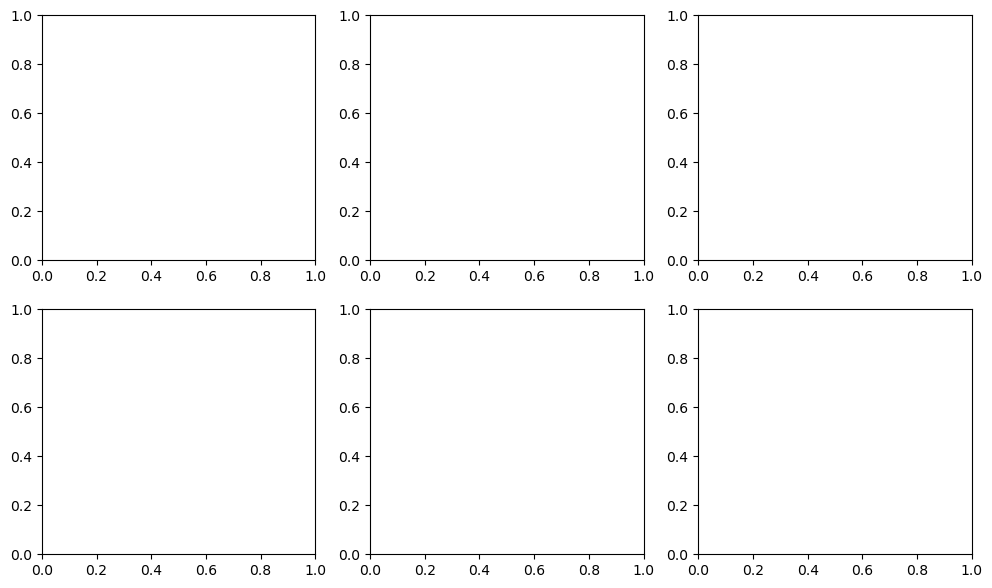

In [9]:
opt.run(working_dir=f'{Config.RESULTS_PATH}/opts')

In [25]:
initial_params_y = initial_points_y[1:-1] # remove the start and end points, as these will not be varied
bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size

def norm_splitter(params = initial_params_y):
    params = np.array(params)
    points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
    points_y = np.concatenate(([initial_points_y[0]], params, [initial_points_y[-1]]))
    
    polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
    
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

normal_poly = FunctionDefinedPolygon_GL(func = norm_splitter, 
                                initial_params = initial_params_y,
                                bounds = bounds,
                                z = 0.0,
                                depth = depth,
                                eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

normal_geo = [normal_poly]
create_waveguides(0, normal_geo)

norm_geo = Geometry_GL(normal_geo, 'add')

# define figure of merit
fom3 = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental mode', direction = 'Forward', 
                target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

optimizer = ScipyOptimizers(max_iter = 15, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

wavelengths = Wavelengths(start = 1525e-9, stop = 1575e-9, points = 11)

opt3 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom3, geometry = norm_geo, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)


Accurate interface detection enabled


Wavelength range of source object will be superseded by the global settings.
Running scipy optimizer
bounds = [[0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]]
start = [0.285 0.32  0.355 0.39  0.425 0.46  0.495 0.53  0.565]
Making forward solve
Making adjoint solve
[2.85e-07 3.20e-07 3.55e-07 3.90e-07 4.25e-07 4.60e-07 4.95e-07 5.30e-07
 5.65e-07]
Running solves
Processing forward solve
FOM = 0.7086814073770356
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[6.70241394e-07 3.44377321e-07 1.00000000e-07 1.00000000e-07
 1.88460407e-07 8.00000000e-07 8.00000000e-07 8.00000000e-07
 6.94126795e-07]
Running solves
Processing forward solve
FOM = 0.6457198787160607
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........Making forward solve
Making adjoint solve
[3.86618615e-07 3.26430227e-07 2.87736338e-07 3.13504071e-07
 3.62605807e-07 5.49684882e-07 5.75452615e-07 6.01220348e-07
 5.99060945e-07]
Running solves
Processing forward solve
FOM = 0.8807937307002067
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.85438064e-07 2.89722112e-07 2.68976362e-07 2.88307449e-07
 3.88953882e-07 5.64276411e-07 5.62796036e-07 5.90278933e-07
 5.58422474e-07]
Running solves
Processing forward solve
FOM = 0.9193104325069907
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.91517334e-07 2.56349763e-07 2.58863937e-07 2.51574091e-07
 4.08231868e-07 5.80927036e-07 5.67576490e-07 5.91447417e-07
 5.04882508e-07]
Running solves
Processing forward solve
FOM = 0.93262439916833
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.91287178e-07 2.56639404e-07 2.48101146e-07 2.56145910e-07
 4.15567868e-07 5.87157287e-07 5.77763736e-07 5.92857163e-07
 5.11955821e-07]
Running solves
Processing forward solve
FOM = 0.9343359111464082
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.83948135e-07 2.54223103e-07 2.44525027e-07 2.57746543e-07
 4.31061919e-07 5.95663883e-07 5.89474313e-07 5.96096408e-07
 5.12987163e-07]
Running solves
Processing forward solve
FOM = 0.9360561944950667
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.59326666e-07 2.66175149e-07 2.47570157e-07 2.67043715e-07
 4.72885505e-07 6.07392109e-07 6.08213273e-07 6.09600538e-07
 5.18391188e-07]
Running solves
Processing forward solve
FOM = 0.9395068425200288
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.50720413e-07 2.52723612e-07 2.50898117e-07 2.67645497e-07
 4.97005055e-07 6.08738101e-07 6.13220286e-07 6.20157844e-07
 5.23893156e-07]
Running solves
Processing forward solve
FOM = 0.9413900174416888
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.09988355e-07 2.17876661e-07 2.62372848e-07 2.80158621e-07
 6.01999717e-07 6.12604908e-07 6.28878569e-07 6.60452085e-07
 5.35995624e-07]
Running solves
Processing forward solve
FOM = 0.9372837549841107
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........Making forward solve
Making adjoint solve
[3.37484706e-07 2.41400245e-07 2.54626781e-07 2.71711583e-07
 5.31122618e-07 6.09994603e-07 6.18308378e-07 6.33251284e-07
 5.27825801e-07]
Running solves
Processing forward solve
FOM = 0.9425472966691555
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.25888267e-07 2.36556550e-07 2.52978822e-07 2.69656182e-07
 5.38417598e-07 6.05205890e-07 6.06450439e-07 6.33603790e-07
 5.24626138e-07]
Running solves
Processing forward solve
FOM = 0.9429581030494206
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.23192899e-07 2.37123397e-07 2.53345461e-07 2.71072448e-07
 5.49148711e-07 6.06594710e-07 6.06525350e-07 6.35546858e-07
 5.27101658e-07]
Running solves
Processing forward solve
FOM = 0.9433316699922837
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.22095545e-07 2.45700404e-07 2.55234779e-07 2.78195721e-07
 5.82192040e-07 6.11889033e-07 5.99351024e-07 6.35699025e-07
 5.44824865e-07]
Running solves
Processing forward solve
FOM = 0.9438313127904089
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.15767751e-07 2.40112822e-07 2.53349065e-07 2.83967163e-07
 5.99346849e-07 6.12059074e-07 5.93542757e-07 6.36541572e-07
 5.48464339e-07]
Running solves
Processing forward solve
FOM = 0.9443280943961785
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.08069017e-07 2.36178075e-07 2.51281555e-07 3.03982656e-07
 6.31102466e-07 6.15959479e-07 5.83755923e-07 6.36218479e-07
 5.54567307e-07]
Running solves
Processing forward solve
FOM = 0.945040354231542
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[2.65170937e-07 2.28584308e-07 2.50179536e-07 3.86108276e-07
 7.54798998e-07 6.30918506e-07 5.60238968e-07 6.34616993e-07
 5.80865910e-07]
Running solves
Processing forward solve
FOM = 0.9417816072793113
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........Making forward solve
Making adjoint solve
[2.91560737e-07 2.33255799e-07 2.50857470e-07 3.35586698e-07
 6.78704060e-07 6.21716096e-07 5.74705996e-07 6.35602186e-07
 5.64687683e-07]
Running solves
Processing forward solve
FOM = 0.9461156783047519
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[2.58587828e-07 2.24000380e-07 2.61047154e-07 4.36376882e-07
 7.75392404e-07 6.26581544e-07 5.61275183e-07 6.29861222e-07
 5.81753778e-07]
Running solves
Processing forward solve
FOM = 0.940202455305459
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........Making forward solve
Making adjoint solve
[2.80714205e-07 2.30211203e-07 2.54209396e-07 3.68741916e-07
 7.10509965e-07 6.23316599e-07 5.70287892e-07 6.33713680e-07
 5.70301624e-07]
Running solves
Processing forward solve
FOM = 0.9470630477125555
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.........

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Number of FOM evaluations: 15
FINAL FOM = 0.9470630477125555
FINAL PARAMETERS = [2.80714205e-07 2.30211203e-07 2.54209396e-07 3.68741916e-07
 7.10509965e-07 6.23316599e-07 5.70287892e-07 6.33713680e-07
 5.70301624e-07]


(0.9470630477125555,
 array([2.80714205e-07, 2.30211203e-07, 2.54209396e-07, 3.68741916e-07,
        7.10509965e-07, 6.23316599e-07, 5.70287892e-07, 6.33713680e-07,
        5.70301624e-07]))

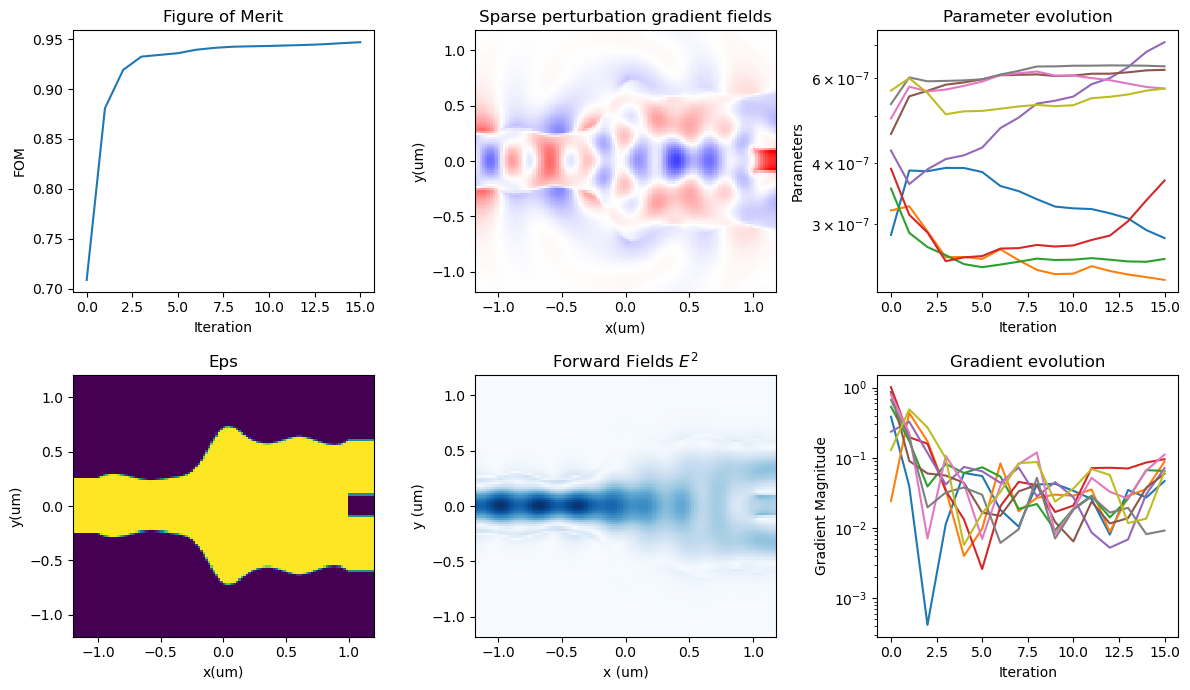

In [26]:
opt3.run(working_dir=f'{Config.RESULTS_PATH}/opts')

Lets also get the normal optimal parameters for this case...

In [28]:
opt3.params_hist[-1]

array([2.80714205e-07, 2.30211203e-07, 2.54209396e-07, 3.68741916e-07,
       7.10509965e-07, 6.23316599e-07, 5.70287892e-07, 6.33713680e-07,
       5.70301624e-07])

In [56]:
robust_params = opt.params_hist[-1]

In [57]:
robust_params

array([2.15725847e-07, 2.31312344e-07, 3.44286467e-07, 4.89184639e-07,
       6.19561747e-07, 6.24840208e-07, 6.55610807e-07, 6.25119824e-07,
       6.11729180e-07])

In [ ]:
normal_params = []
robust_params = []

Now we'll do a robust optimization test. We'll adjust values as such
-20, -15, -10, -5, 0, 5, 10, 15, 20
For each of these the y will be added and a forward run done...

In [43]:
y_range = [-40e-9, -30e-9, -20e-9, -10e-9, 0, 10e-9, 20e-9, 30e-9, 40e-9]
normal_fom = []
robust_fom = []
for a in y_range:
    dy = a
    def splitter(params = initial_params_y):
        params = np.array(params)
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] + dy], params + dy, [initial_points_y[-1] + dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.2e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points
    
    test = FunctionDefinedPolygon_GL(func = splitter, initial_params = initial_params_y,bounds = bounds,z = 0.0, depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
    test_geo = [test]
    create_waveguides(dy, test_geo)
    fin_geo = Geometry_GL(test_geo, 'add')
    opt4 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom3, geometry = fin_geo, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt4.initialize()
    normal_fom.append(opt4.run_forward_simulation(opt3.params_hist[-1] + dy))

Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be supersede

In [44]:
normal_fom

[0.8837516682134661,
 0.9049444434527141,
 0.9251612009746258,
 0.9384753539583557,
 0.9470630477125555,
 0.9494733647911503,
 0.9480770635382761,
 0.94151209734606,
 0.9324905439012049]

In [59]:
y_range = [-40e-9, -30e-9, -20e-9, -10e-9, 0, 10e-9, 20e-9, 30e-9, 40e-9]
normal_fom = []
robust_fom = []
for a in y_range:
    dy = a
    def splitter(params = initial_params_y):
        params = np.array(params)
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.2e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points
    
    test = FunctionDefinedPolygon_GL(func = splitter, initial_params = initial_params_y,bounds = bounds,z = 0.0, depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
    test_geo = [test]
    create_waveguides(dy, test_geo)
    fin_geo = Geometry_GL(test_geo, 'add')
    opt4 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom3, geometry = fin_geo, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt4.initialize()
    robust_fom.append(opt4.run_forward_simulation(opt.params_hist[-1] + dy))

Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be superseded by the global settings.
Accurate interface detection enabled
Wavelength range of source object will be supersede

<Figure size 800x600 with 0 Axes>

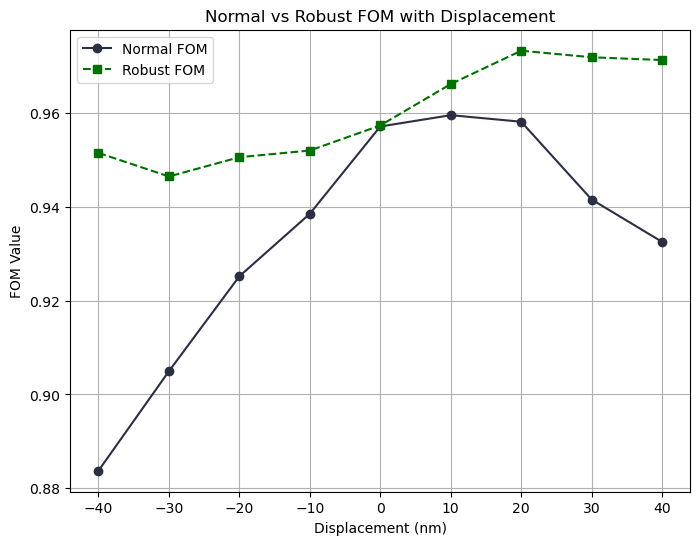

In [67]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(8, 6))
displacements = [-40, -30, -20, -10, 0, 10, 20, 30, 40]

plt.figure(figsize=(8, 6))
plt.plot(displacements, normal_fom, label='Normal FOM', color='#2B2F42', linestyle='-', marker='o')
plt.plot(displacements, robust_fom, label='Robust FOM', color='#007000', linestyle='--', marker='s')

# Adding labels and title
plt.xlabel('Displacement (nm)')
plt.ylabel('FOM Value')
plt.title('Normal vs Robust FOM with Displacement')

# Adding legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [23]:
def robust_opt(num_params):
    '''Creates a splitter polygon using cubic spline interpolation.'''

    eps_in = Material(name = 'Si: non-dispersive')
    eps_out = Material(name = 'SiO2: non-dispersive')

    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, num_params)
    initial_points_y = np.linspace(0.25e-6, 0.6e-6, num_params)

    initial_params_y = initial_points_y[1:-1] # remove the start and end points, as these will not be varied
    bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size
    dy = 40e-9

    def splitter(params = initial_params_y):
        params = np.array(params)
        params = params + dy
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    def splitter2(params = initial_params_y):
        
        params = np.array(params)
        params = params - dy
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] - dy], params, [initial_points_y[-1] - dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    depth = 220.0e-9
    polygon1 = FunctionDefinedPolygon_GL(func = splitter, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

    polygon2 = FunctionDefinedPolygon_GL(func = splitter2, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
    
    polygons1 = [polygon1]
    polygons2 = [polygon2]
            
    create_waveguides(40e-9, polygons1)
    create_waveguides(-40e-9, polygons2)

    # define figure of merit
    fom1 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)
    fom2 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

    optimizer = ScipyOptimizers(max_iter = 15, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    geo1 = Geometry_GL(polygons1, 'add')
    geo2 = Geometry_GL(polygons2, 'add')

    opt1 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom1, geometry = geo1, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt2 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom2, geometry = geo2, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt = opt1 + opt2
    return opt

def normal_opt(num_params):
    eps_in = Material(name = 'Si: non-dispersive')
    eps_out = Material(name = 'SiO2: non-dispersive')

    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, num_params)
    initial_points_y = np.linspace(0.25e-6, 0.6e-6, num_params)
    
    initial_params_y = initial_points_y[1:-1] # remove the start and end points, as these will not be varied
    bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size

    def norm_splitter(params = initial_params_y):
        params = np.array(params)
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0]], params, [initial_points_y[-1]]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    normal_poly = FunctionDefinedPolygon_GL(func = norm_splitter, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth=220e-9,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

    normal_geo = [normal_poly]
    create_waveguides(0, normal_geo)

    norm_geo = Geometry_GL(normal_geo, 'add')

    # define figure of merit
    fom3 = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental mode', direction = 'Forward', 
                    target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

    optimizer = ScipyOptimizers(max_iter = 15, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    wavelengths = Wavelengths(start = 1525e-9, stop = 1575e-9, points = 11)

    opt = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom3, geometry = norm_geo, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    return opt
            

In [123]:

start_x = -1.0e-6
stop_x = 1e-6
start_y = 0.25e-6
stop_y = 0.6e-6

def create_waveguides(dy, polygons):
    
    eps_in = Material(name = 'Si: non-dispersive')
    eps_out = Material(name = 'SiO2: non-dispersive')
    def input_wg(params = None):
        x =  np.array([(start_x-2e-6, start_y + dy), (start_x-2e-6, -start_y - dy), (start_x, -start_y - dy), (start_x, start_y + dy)])
        return x
    def output_wg_top(params=None):
        x =  np.array([(stop_x + 2e-6, stop_y + dy), (stop_x, stop_y + dy), (stop_x, stop_y - 2 * start_y - dy), (stop_x + 2e-6, stop_y - 2 * start_y - dy)])
        return x
    def output_wg_bottom(params=None):
        x =  np.array([(stop_x + 2e-6, -stop_y - dy), (stop_x + 2e-6, -stop_y + 2 * start_y + dy),  (stop_x, -stop_y + 2 * start_y + dy), (stop_x, -stop_y - dy)])
        return x
        
    for func in [input_wg, output_wg_top, output_wg_bottom]:
        polygons.append(FunctionDefinedPolygon_GL(
                func=func,
                initial_params=np.empty(0),
                bounds=np.empty((0, 2)),
                z=0.0,
                depth=220e-9,
                eps_out=eps_out,  # Use the variable passed to the function
                eps_in=eps_in,
        ))

In [25]:
y_range = [-40e-9]
params = [15]
total_normal = []
total_robust = []

for i in params:
    opt1 = normal_opt(i)
    opt2 = robust_opt(i)
    opt1.run()
    opt2.run()
    normal_fom = []
    robust_fom = []
    for a in y_range:
        dy = a
        initial_points_x = np.linspace(-1.0e-6, 1.0e-6, i)
        initial_points_y = np.linspace(0.25e-6, 0.6e-6, i)
        eps_in = Material(name = 'Si: non-dispersive')
        eps_out = Material(name = 'SiO2: non-dispersive')

        initial_params_y = initial_points_y[1:-1] # remove the start and end points, as these will not be varied
        bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size
        def splitter3(params = initial_params_y):
            params = np.array(params)
            points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
            points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
            
            polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
            interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
            polygon_points_y = interpolator(polygon_points_x)
            polygon_points_y = np.clip(polygon_points_y, 0.2e-6, 0.8e-6)
            
            polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
            polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
            polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
            return polygon_points
        
        test = FunctionDefinedPolygon_GL(func = splitter3, initial_params = initial_params_y,bounds = bounds,z = 0.0, depth=220e-9,
                                        eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
        test_geo = [test]
        create_waveguides(dy, test_geo)
        fin_geo = Geometry_GL(test_geo, 'add')
        fom4 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

        optimizer2 = ScipyOptimizers(max_iter = 1, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)
        wavelengths2 = Wavelengths(start = 1525e-9, stop = 1575e-9, points = 11)
        opt4 = OptimizationGL(base_script = base_script, wavelengths = wavelengths2, fom = fom4, geometry = fin_geo, optimizer = optimizer2, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
        opt4.initialize()
        print(opt1.params_hist[-1])
        normal_fom.append(opt4.run_forward_simulation(opt1.params_hist[-1] + dy))
        robust_fom.append(opt4.run_forward_simulation(opt2.params_hist[-1] + dy))
    total_normal.append(normal_fom)
    total_robust.append(robust_fom)

Accurate interface detection enabled
Accurate interface detection enabled
Accurate interface detection enabled


LumApiError: 'addfdtd is not a valid function or variable name'

<Figure size 800x600 with 0 Axes>

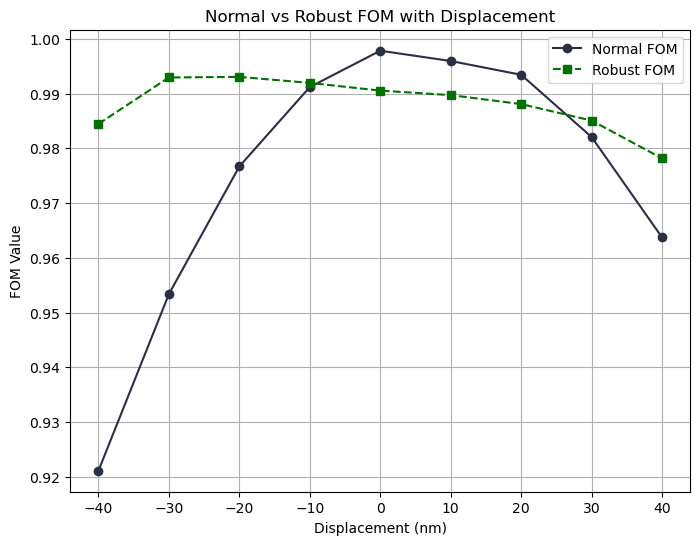

In [116]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(8, 6))
displacements = [-40, -30, -20, -10, 0, 10, 20, 30, 40]

robust_fom = [0.9844531933711893,
 0.9929406292370792,
 0.9930487681030402,
 0.9919448362711044,
 0.9905420770626018,
 0.9897174034384865,
 0.9880781088376343,
 0.9850606873318494,
 0.9781646192672886]

asfa = [0.9072915708452446,
 0.9404494169682215,
 0.9676178447276861,
 0.984942480032303,
 0.9937235250561713,
 0.9914507556272837,
 0.9873630898150026,
 0.9772153493584689,
 0.9564731043209477]



plt.figure(figsize=(8, 6))
plt.plot(displacements, normal_fom, label='Normal FOM', color='#2B2F42', linestyle='-', marker='o')
plt.plot(displacements, robust_fom, label='Robust FOM', color='#007000', linestyle='--', marker='s')

# Adding labels and title
plt.xlabel('Displacement (nm)')
plt.ylabel('FOM Value')
plt.title('Normal vs Robust FOM with Displacement')

# Adding legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Display the plot
plt.show()

So clearly it doesnt work that well without some level of global optimization. But I'm not sure if my current robust optimization framework supports multiple objectives... probably doesnt. 

Maybe I can start with a global optimized device?

In [2]:
from geometries.ybranch import ybranch_2D

taper, base_script = ybranch_2D(num_params = 5, poly_wg = True, init_params=[3.00000000e-07, 4.33333333e-07, 5.00000000e-07, 5.00000000e-07, 6.33333333e-07])

In [9]:
def optimizer2D(polygon, base_script, max_iter = 555):
    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    fom = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental mode', direction = 'Forward', 
                    target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

    optimizer = ScipyOptimizers(max_iter = 10, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    opt = OptimizationGL(base_script=base_script, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, 
                       use_var_fdtd=True, store_all_simulations = False)
    return opt

def optimizer3D(polygon, base_script, max_iter = 1200):
    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    fom = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental TE mode', direction = 'Forward', 
                    target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1) # for 3D, we need to specify TE/TM

    optimizer = ScipyOptimizers(max_iter = 10, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)


    opt = OptimizationGL(base_script=base_script, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, 
                       use_var_fdtd=False, store_all_simulations = False, GPU = True) # and set varFDTD to False. Set GPU to True if you have one.
    return opt

In [110]:
from geometries.ybranch import ybranch_3D

ybr, base_script = ybranch_3D(mesh = 3, num_params = 13, poly_wg = True, init_params=ynew)

opt = optimizer3D(ybr, base_script)

Accurate interface detection enabled


Wavelength range of source object will be superseded by the global settings.


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:19: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super().setup(fig, dpi, frame_prefix, clear_temp = False)


Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.35389547 0.36379828 0.32008543 0.26313395 0.23440046 0.27965992
 0.4190819  0.56609591 0.63261175 0.6312002  0.59801917 0.562914
 0.55415188]
Making forward solve
Making adjoint solve
[3.53895473e-07 3.63798276e-07 3.20085430e-07 2.63133955e-07
 2.34400463e-07 2.79659925e-07 4.19081898e-07 5.66095913e-07
 6.32611749e-07 6.31200200e-07 5.98019174e-07 5.62914004e-07
 5.54151882e-07]
Running solves
Processing forward solve
FOM = 0.9932163897854029
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[5.38919633e-07 3.19246187e-07 2.67570770e-07 3.76314426e-07
 4.85131295e-07 2.10771733e-07 4.86641077e-07 6.83446059e-07
 6.87253770e-07 6.46063120e-07 6.48928026e-07 8.00000000e-07
 4.68634991e-07]
Running solves
Processing forward solve
FOM = 0.8296595711304295
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.96409829e-07 3.53561216e-07 3.08018752e-07 2.89140261e-07
 2.92012722e-07 2.63830980e-07 4.34605465e-07 5.93060315e-07
 6.45167246e-07 6.34615362e-07 6.09716873e-07 6.17390990e-07
 5.34502040e-07]
Running solves
Processing forward solve
FOM = 0.9883273958214875
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.64906888e-07 3.61146830e-07 3.16960104e-07 2.69869708e-07
 2.49322304e-07 2.75560155e-07 4.23102574e-07 5.73079818e-07
 6.35863680e-07 6.32084743e-07 6.01048

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.57463168e-07 3.63708529e-07 3.17586663e-07 2.66299462e-07
 2.39224191e-07 2.76934515e-07 4.20911204e-07 5.68110575e-07
 6.33922958e-07 6.31500476e-07 5.98319877e-07 5.68042197e-07
 5.52049587e-07]
Running solves
Processing forward solve
FOM = 0.9945610298207127
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.50617825e-07 3.93743356e-07 2.63429353e-07 2.98690323e-07
 2.29756038e-07 2.26671511e-07 4.37749144e-07 5.54459294e-07
 6.41158083e-07 6.31353525e-07 5.71148397e-07 5.80383691e-07
 5.37900073e-07]
Running solves
Processing forward solve
FOM = 0.9654707168048497
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.56206879e-07 3.69220657e-07 3.07647468e-07 2.72243980e-07
 2.37486552e-07 2.67710020e-07 4.24001379e-07 5.65605230e-07
 6.35250781e-07 6.31473507e-07 5.93333243e-07 5.70307164e-07
 5.49452804e-07]
Running solves
Processing forward solve
FOM = 0.9957030131657528
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.55073580e-07 3.70826590e-07 3.03172981e-07 2.73153949e-07
 2.38697205e-07 2.64231624e-07 4.24648195e-07 5.64653196e-07
 6.34907832e-07 6.30640453e-07 5.91678267e-07 5.72558818e-07
 5.47733748e-07]
Running solves
Processing forward solve
FOM = 0.9960058611192613
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.51778806e-07 3.75891132e-07 2.96447863e-07 2.74089593e-07
 2.41740661e-07 2.58986350e-07 4.25687412e-07 5.62766272e-07
 6.34516914e-07 6.29861006e-07 5.89506941e-07 5.76175604e-07
 5.46763862e-07]
Running solves
Processing forward solve
FOM = 0.996179881026099
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.48010751e-07 3.78811254e-07 2.93491027e-07 2.71010581e-07
 2.46091137e-07 2.57904438e-07 4.25337823e-07 5.62091845e-07
 6.33503890e-07 6.28929087e-07 5.89676164e-07 5.80026600e-07
 5.46586465e-07]
Running solves
Processing forward solve
FOM = 0.9966815370700753
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.11540455e-07 3.94741441e-07 2.82028013e-07 2.55760818e-07
 2.72714581e-07 2.64472798e-07 4.29817579e-07 5.60688115e-07
 6.22243018e-07 6.18059036e-07 5.87508058e-07 6.08027343e-07
 5.50384344e-07]
Running solves
Processing forward solve
FOM = 0.9871728762653085
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.42990093e-07 3.81004272e-07 2.91912980e-07 2.68911233e-07
 2.49756234e-07 2.58808667e-07 4.25954526e-07 5.61898601e-07
 6.31953670e-07 6.27432669e-07 5.89377693e-07 5.83881302e-07
 5.47109297e-07]
Running solves
Processing forward solve
FOM = 0.9971032118289107
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.18274054e-07 3.84512409e-07 2.95914445e-07 2.52691747e-07
 2.66809368e-07 2.73992499e-07 4.27341431e-07 5.64906297e-07
 6.21781216e-07 6.18582523e-07 5.93340773e-07 6.02272152e-07
 5.51941687e-07]
Running solves
Processing forward solve
FOM = 0.9926260986250085
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.38567911e-07 3.81631946e-07 2.92628920e-07 2.66009250e-07
 2.52807373e-07 2.61525351e-07 4.26202670e-07 5.62436737e-07
 6.30133619e-07 6.25849205e-07 5.90086765e-07 5.87171784e-07
 5.47973906e-07]
Running solves
Processing forward solve
FOM = 0.9974453148167193
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.23836692e-07 3.80158752e-07 3.00120218e-07 2.58509235e-07
 2.58052242e-07 2.78127710e-07 4.29297685e-07 5.66172486e-07
 6.22570788e-07 6.19549620e-07 5.91691580e-07 5.97614945e-07
 5.50944562e-07]
Running solves
Processing forward solve
FOM = 0.9963749794783241
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............Making forward solve
Making adjoint solve
[3.33778402e-07 3.81152972e-07 2.95064539e-07 2.63570797e-07
 2.54512619e-07 2.66923218e-07 4.27208941e-07 5.63651328e-07
 6.27674743e-07 6.23801043e-07 5.90608533e-07 5.90567132e-07
 5.48939745e-07]
Running solves
Processing forward solve
FOM = 0.997822498245586
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Making forward solve
Making adjoint solve
[3.35540763e-07 3.79385084e-07 2.98723665e-07 2.62170053e-07
 2.52552085e-07 2.67455783e-07 4.28359850e-07 5.64286400e-07
 6.26934496e-07 6.23867534e-07 5.90571778e-07 5.90422263e-07
 5.48371847e-07]
Running solves
Processing forward solve
FOM = 0.9978254615145331
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
.............

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\fields.py:235: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx*1e6, yy*1e6,np.abs(Ex**2+Ey**2+Ez**2) ,cmap=plt.get_cmap(cmap))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_gradients.pcolormesh(xx*1e6, yy*1e6, Sparse_pert, vmin=-max_val, vmax=max_val, cmap = plt.get_cmap('bwr'))
C:\Program Files/Lumer

Saved frame
Number of FOM evaluations: 10
FINAL FOM = 0.9978254615145331
FINAL PARAMETERS = [3.35540763e-07 3.79385084e-07 2.98723665e-07 2.62170053e-07
 2.52552085e-07 2.67455783e-07 4.28359850e-07 5.64286400e-07
 6.26934496e-07 6.23867534e-07 5.90571778e-07 5.90422263e-07
 5.48371847e-07]


(0.9978254615145331,
 array([3.35540763e-07, 3.79385084e-07, 2.98723665e-07, 2.62170053e-07,
        2.52552085e-07, 2.67455783e-07, 4.28359850e-07, 5.64286400e-07,
        6.26934496e-07, 6.23867534e-07, 5.90571778e-07, 5.90422263e-07,
        5.48371847e-07]))

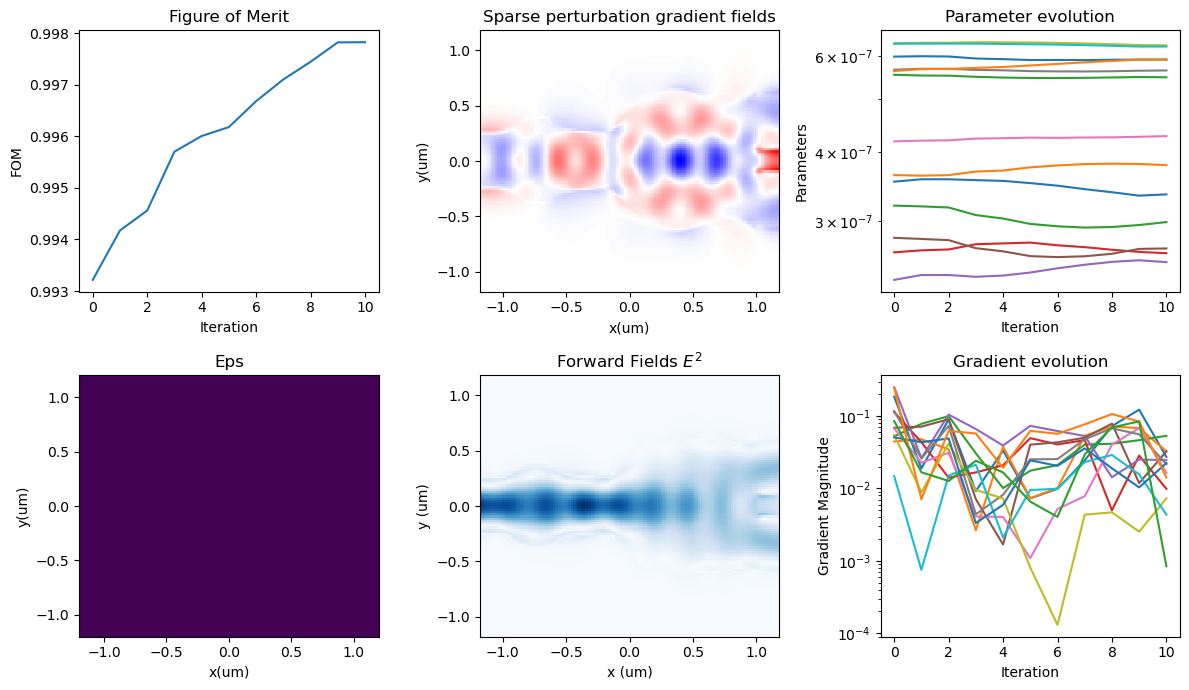

In [111]:
opt.run()

In [112]:
normal_params = opt.params_hist[-1]

In [113]:
normal_params

array([3.35540763e-07, 3.79385084e-07, 2.98723665e-07, 2.62170053e-07,
       2.52552085e-07, 2.67455783e-07, 4.28359850e-07, 5.64286400e-07,
       6.26934496e-07, 6.23867534e-07, 5.90571778e-07, 5.90422263e-07,
       5.48371847e-07])

In [11]:
init_params = np.array([3.63798276e-07, 2.63133955e-07, 2.79659925e-07, 5.66095913e-07, 6.31200200e-07, 5.62914004e-07])

In [139]:
normal_params

array([3.35540763e-07, 3.79385084e-07, 2.98723665e-07, 2.62170053e-07,
       2.52552085e-07, 2.67455783e-07, 4.28359850e-07, 5.64286400e-07,
       6.26934496e-07, 6.23867534e-07, 5.90571778e-07, 5.90422263e-07,
       5.48371847e-07])

ROBUST TESTER

In [114]:
y_range = [-40e-9, -30e-9, -20e-9, -10e-9, 0, 10e-9, 20e-9, 30e-9, 40e-9]

opt.initialize()

normal_fom = []
for a in y_range:
    new_params = normal_params + a
    normal_fom.append(opt.run_forward_simulation(new_params))

Wavelength range of source object will be superseded by the global settings.


In [115]:
normal_fom

[0.9211238812168039,
 0.953386523405839,
 0.9766995653591256,
 0.9911893102839795,
 0.997825461514533,
 0.9959452704113922,
 0.993431211992536,
 0.9820583214620299,
 0.9637174317133983]

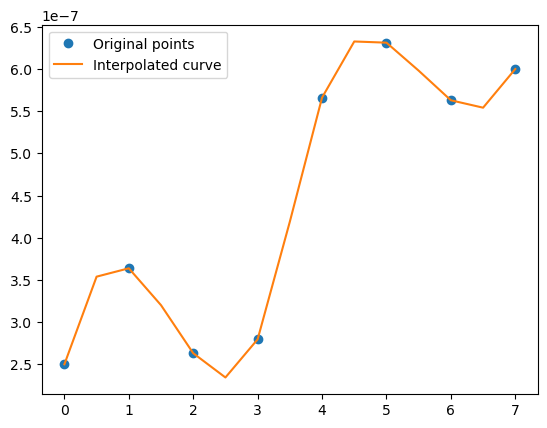

In [105]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Original x and y values
x = np.arange(8)  # These are the indices of your values
y = np.array([2.5e-7, 3.63798276e-07, 2.63133955e-07, 2.79659925e-07, 5.66095913e-07, 6.31200200e-07, 5.62914004e-07, 6e-7])

# Create a cubic interpolator
cubic_interp = interp1d(x, y, kind='cubic')

# Generate new x values (you can increase the resolution by using smaller steps)
x_new = np.linspace(0, 7, 15)  # 50 points between the original x values

# Interpolate the new y values
y_new = cubic_interp(x_new)

# Plot to visualize
plt.plot(x, y, 'o', label='Original points')
plt.plot(x_new, y_new, '-', label='Interpolated curve')
plt.legend()
plt.show()


In [108]:
ynew = y_new[1:-1]

In [106]:
init_new

array([2.45740499e-07, 2.51558881e-07, 2.62883771e-07, 2.75143794e-07,
       2.92810443e-07, 3.56526673e-07, 4.90177821e-07, 6.14447276e-07,
       6.52276190e-07, 6.38838714e-07, 6.25850482e-07, 6.18960075e-07,
       6.12299309e-07])

In [34]:
def robust_opt(num_params):
    '''Creates a splitter polygon using cubic spline interpolation.'''

    eps_in = Material(name = 'Si: non-dispersive')
    eps_out = Material(name = 'SiO2: non-dispersive')

    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, num_params)
    initial_points_y = np.linspace(0.25e-6, 0.6e-6, num_params)

    initial_params_y = init_new
    bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size
    dy = 40e-9

    def splitter(params = initial_params_y):
        params = np.array(params)
        params = params + dy
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    def splitter2(params = initial_params_y):
        
        params = np.array(params)
        params = params - dy
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] - dy], params, [initial_points_y[-1] - dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    depth = 220.0e-9
    polygon1 = FunctionDefinedPolygon_GL(func = splitter, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)

    polygon2 = FunctionDefinedPolygon_GL(func = splitter2, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
    
    polygons1 = [polygon1]
    polygons2 = [polygon2]
            
    create_waveguides(40e-9, polygons1)
    create_waveguides(-40e-9, polygons2)

    # define figure of merit
    fom1 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)
    fom2 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

    optimizer = ScipyOptimizers(max_iter = 25, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    geo1 = Geometry_GL(polygons1, 'add')
    geo2 = Geometry_GL(polygons2, 'add')

    opt1 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom1, geometry = geo1, optimizer = optimizer, use_var_fdtd=False, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt2 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom2, geometry = geo2, optimizer = optimizer, use_var_fdtd=False, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt = opt1 + opt2
    return opt

In [35]:
opt = robust_opt(15)

Accurate interface detection enabled
Accurate interface detection enabled


Initializing super optimization
Checking for one forward simulation :	More than One Geometry, one forward simulation is not possible
Wavelength range of source object will be superseded by the global settings.
Wavelength range of source object will be superseded by the global settings.


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:19: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super().setup(fig, dpi, frame_prefix, clear_temp = False)


Running scipy optimizer
bounds = [[0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]
 [0.1 0.8]]
start = [0.2457405  0.25155888 0.26288377 0.27514379 0.29281044 0.35652667
 0.49017782 0.61444728 0.65227619 0.63883871 0.62585048 0.61896008
 0.61229931]
Making forward solves
[2.45740499e-07 2.51558881e-07 2.62883771e-07 2.75143794e-07
 2.92810443e-07 3.56526673e-07 4.90177821e-07 6.14447276e-07
 6.52276190e-07 6.38838714e-07 6.25850482e-07 6.18960075e-07
 6.12299309e-07]
[2.45740499e-07 2.51558881e-07 2.62883771e-07 2.75143794e-07
 2.92810443e-07 3.56526673e-07 4.90177821e-07 6.14447276e-07
 6.52276190e-07 6.38838714e-07 6.25850482e-07 6.18960075e-07
 6.12299309e-07]
Running solves
Processing forward solves
FOM = 0.9766676406193204
FOM = 0.9758142776407731
=> Combined FOM = -1.9524819182600934 (1.9524819182600934)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[1.61096554e-07 1.00000000e-07 3.63388428e-07 2.79326054e-07
 2.57773824e-07 3.02738301e-07 5.83506409e-07 6.20868162e-07
 5.34298815e-07 5.02088153e-07 5.67252122e-07 8.00000000e-07
 1.96325024e-07]
[1.61096554e-07 1.00000000e-07 3.63388428e-07 2.79326054e-07
 2.57773824e-07 3.02738301e-07 5.83506409e-07 6.20868162e-07
 5.34298815e-07 5.02088153e-07 5.67252122e-07 8.00000000e-07
 1.96325024e-07]
Running solves
Processing forward solves
FOM = 0.6055040026711486
FOM = 0.3831907781668905
=> Combined FOM = -0.9886947808380391 (0.9886947808380391)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................Making forward solves
[2.40384971e-07 2.41969561e-07 2.69242826e-07 2.75408411e-07
 2.90593632e-07 3.53123415e-07 4.96082837e-07 6.14853534e-07
 6.44811614e-07 6.30186335e-07 6.22142891e-07 6.30414697e-07
 5.85980096e-07]
[2.40384971e-07 2.41969561e-07 2.69242826e-07 2.75408411e-07
 2.9059

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.41113674e-07 2.29262995e-07 2.56485009e-07 2.78625950e-07
 2.85530916e-07 3.37623296e-07 5.05092041e-07 6.17227904e-07
 6.33584306e-07 6.22749414e-07 6.14191533e-07 6.47075181e-07
 5.56572067e-07]
[2.41113674e-07 2.29262995e-07 2.56485009e-07 2.78625950e-07
 2.85530916e-07 3.37623296e-07 5.05092041e-07 6.17227904e-07
 6.33584306e-07 6.22749414e-07 6.14191533e-07 6.47075181e-07
 5.56572067e-07]
Running solves
Processing forward solves
FOM = 0.9832937056396404
FOM = 0.9775557636540269
=> Combined FOM = -1.960849469293667 (1.960849469293667)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................Making forward solves
[2.40675963e-07 2.36895456e-07 2.64148255e-07 2.76693269e-07
 2.88571941e-07 3.46933763e-07 4.99680477e-07 6.15801689e-07
 6.40328221e-07 6.27216554e-07 6.18967680e-07 6.37067717e-07
 5.74236607e-07]
[2.40675963e-07 2.36895456e-07 2.64148255e-07 2.76693269e-07
 2.885719

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.38067110e-07 2.36386435e-07 2.62280153e-07 2.75757636e-07
 2.89304426e-07 3.40199127e-07 5.01604928e-07 6.18403800e-07
 6.38493690e-07 6.28051289e-07 6.21831073e-07 6.41179750e-07
 5.70541682e-07]
[2.38067110e-07 2.36386435e-07 2.62280153e-07 2.75757636e-07
 2.89304426e-07 3.40199127e-07 5.01604928e-07 6.18403800e-07
 6.38493690e-07 6.28051289e-07 6.21831073e-07 6.41179750e-07
 5.70541682e-07]
Running solves
Processing forward solves
FOM = 0.9828400263352984
FOM = 0.9871963483254056
=> Combined FOM = -1.9700363746607041 (1.9700363746607041)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.33901559e-07 2.40366441e-07 2.54448287e-07 2.73248928e-07
 2.92345192e-07 3.25514845e-07 5.03190634e-07 6.24540165e-07
 6.37748095e-07 6.34642949e-07 6.30962982e-07 6.45496404e-07
 5.79515438e-07]
[2.33901559e-07 2.40366441e-07 2.54448287e-07 2.73248928e-07
 2.92345192e-07 3.25514845e-07 5.03190634e-07 6.24540165e-07
 6.37748095e-07 6.34642949e-07 6.30962982e-07 6.45496404e-07
 5.79515438e-07]
Running solves
Processing forward solves
FOM = 0.9770158723491879
FOM = 0.9909792219883227
=> Combined FOM = -1.9679950943375104 (1.9679950943375104)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................Making forward solves
[2.36566622e-07 2.37820088e-07 2.59459008e-07 2.74853965e-07
 2.90399751e-07 3.34909648e-07 5.02176121e-07 6.20614202e-07
 6.38225116e-07 6.30425695e-07 6.25120512e-07 6.42734668e-07
 5.73774152e-07]
[2.36566622e-07 2.37820088e-07 2.59459008e-07 2.74853965e-07
 2.9039

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.35309719e-07 2.37682638e-07 2.51144609e-07 2.74461759e-07
 2.90757218e-07 3.23605644e-07 5.04450339e-07 6.24097138e-07
 6.35575974e-07 6.32540852e-07 6.27625329e-07 6.47723131e-07
 5.73906515e-07][2.35309719e-07 2.37682638e-07 2.51144609e-07 2.74461759e-07
 2.90757218e-07 3.23605644e-07 5.04450339e-07 6.24097138e-07
 6.35575974e-07 6.32540852e-07 6.27625329e-07 6.47723131e-07
 5.73906515e-07]

Running solves
Processing forward solves
FOM = 0.9795842610198243
FOM = 0.9919930404372018
=> Combined FOM = -1.9715773014570261 (1.9715773014570261)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.34273690e-07 2.38871041e-07 2.51822474e-07 2.72904705e-07
 2.89781148e-07 3.26291619e-07 5.05639528e-07 6.23792311e-07
 6.33471116e-07 6.29167504e-07 6.24013488e-07 6.48095362e-07
 5.72892889e-07]
[2.34273690e-07 2.38871041e-07 2.51822474e-07 2.72904705e-07
 2.89781148e-07 3.26291619e-07 5.05639528e-07 6.23792311e-07
 6.33471116e-07 6.29167504e-07 6.24013488e-07 6.48095362e-07
 5.72892889e-07]
Running solves
Processing forward solves
FOM = 0.9819380304720772
FOM = 0.990934418447578
=> Combined FOM = -1.9728724489196552 (1.9728724489196552)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.33194032e-07 2.40063372e-07 2.50894170e-07 2.72325957e-07
 2.88462026e-07 3.25408612e-07 5.07079709e-07 6.24897949e-07
 6.30436050e-07 6.26647634e-07 6.21036725e-07 6.49716303e-07
 5.71832703e-07]
[2.33194032e-07 2.40063372e-07 2.50894170e-07 2.72325957e-07
 2.88462026e-07 3.25408612e-07 5.07079709e-07 6.24897949e-07
 6.30436050e-07 6.26647634e-07 6.21036725e-07 6.49716303e-07
 5.71832703e-07]
Running solves
Processing forward solves
FOM = 0.9832102611430719
FOM = 0.9896878306156206
=> Combined FOM = -1.9728980917586925 (1.9728980917586925)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.32381192e-07 2.40404403e-07 2.53213378e-07 2.71768304e-07
 2.88179037e-07 3.26168713e-07 5.07178902e-07 6.25164241e-07
 6.29597904e-07 6.25744476e-07 6.20429992e-07 6.49681098e-07
 5.71498820e-07]
[2.32381192e-07 2.40404403e-07 2.53213378e-07 2.71768304e-07
 2.88179037e-07 3.26168713e-07 5.07178902e-07 6.25164241e-07
 6.29597904e-07 6.25744476e-07 6.20429992e-07 6.49681098e-07
 5.71498820e-07]
Running solves
Processing forward solves
FOM = 0.9834625406546432
FOM = 0.9897749180200438
=> Combined FOM = -1.973237458674687 (1.973237458674687)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.32671601e-07 2.39472513e-07 2.57621616e-07 2.70644766e-07
 2.89293975e-07 3.26329634e-07 5.07176562e-07 6.25957179e-07
 6.29776790e-07 6.26337769e-07 6.21567123e-07 6.48846038e-07
 5.71393934e-07]
[2.32671601e-07 2.39472513e-07 2.57621616e-07 2.70644766e-07
 2.89293975e-07 3.26329634e-07 5.07176562e-07 6.25957179e-07
 6.29776790e-07 6.26337769e-07 6.21567123e-07 6.48846038e-07
 5.71393934e-07]
Running solves
Processing forward solves
FOM = 0.9827445904208078
FOM = 0.9900548770246004
=> Combined FOM = -1.9727994674454081 (1.9727994674454081)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................Making forward solves
[2.32437287e-07 2.40224399e-07 2.54064873e-07 2.71551281e-07
 2.88394398e-07 3.26199797e-07 5.07178450e-07 6.25317405e-07
 6.29632457e-07 6.25859077e-07 6.20649640e-07 6.49519798e-07
 5.71478560e-07][2.32437287e-07 2.40224399e-07 2.54064873e-07 2.71551281e-07
 2.88394

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.32650581e-07 2.39677401e-07 2.54710494e-07 2.71415780e-07
 2.88509908e-07 3.25510846e-07 5.07401167e-07 6.25867357e-07
 6.29327887e-07 6.26010422e-07 6.20770869e-07 6.49669486e-07
 5.71149155e-07][2.32650581e-07 2.39677401e-07 2.54710494e-07 2.71415780e-07
 2.88509908e-07 3.25510846e-07 5.07401167e-07 6.25867357e-07
 6.29327887e-07 6.26010422e-07 6.20770869e-07 6.49669486e-07
 5.71149155e-07]

Running solves
Processing forward solves
FOM = 0.9831300201871116
FOM = 0.9901804675767407
=> Combined FOM = -1.9733104877638523 (1.9733104877638523)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.32950924e-07 2.39269336e-07 2.55245763e-07 2.71304652e-07
 2.88430959e-07 3.24818484e-07 5.07639373e-07 6.26527988e-07
 6.28616121e-07 6.25906702e-07 6.20338434e-07 6.49797583e-07
 5.70589029e-07]
[2.32950924e-07 2.39269336e-07 2.55245763e-07 2.71304652e-07
 2.88430959e-07 3.24818484e-07 5.07639373e-07 6.26527988e-07
 6.28616121e-07 6.25906702e-07 6.20338434e-07 6.49797583e-07
 5.70589029e-07]
Running solves
Processing forward solves
FOM = 0.9831566674712612
FOM = 0.9901971384884053
=> Combined FOM = -1.9733538059596665 (1.9733538059596665)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................

C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\gradients.py:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_eps.pcolormesh(xx*1e6, yy*1e6, np.real(np.transpose(eps)))#, cmap=plt.get_cmap('bwr'))
C:\Program Files/Lumerical

Saved frame
Making forward solves
[2.35090719e-07 2.37610827e-07 2.58398299e-07 2.70445854e-07
 2.87903166e-07 3.22423996e-07 5.10065372e-07 6.30497539e-07
 6.25064090e-07 6.24446895e-07 6.17365333e-07 6.50162609e-07
 5.67586863e-07]
[2.35090719e-07 2.37610827e-07 2.58398299e-07 2.70445854e-07
 2.87903166e-07 3.22423996e-07 5.10065372e-07 6.30497539e-07
 6.25064090e-07 6.24446895e-07 6.17365333e-07 6.50162609e-07
 5.67586863e-07]
Running solves
Processing forward solves
FOM = 0.9834851816915484
FOM = 0.9894121656032251
=> Combined FOM = -1.9728973472947735 (1.9728973472947735)
Making adjoint solves
Processing adjoint solves
Getting d eps: dx = 2e-09
Getting d eps: dx = 2e-09
..........................Making forward solves
[2.33744393e-07 2.38654336e-07 2.56414771e-07 2.70986196e-07
 2.88235245e-07 3.23930571e-07 5.08538970e-07 6.27999958e-07
 6.27298974e-07 6.25365383e-07 6.19235963e-07 6.49932940e-07
 5.69475780e-07]
[2.33744393e-07 2.38654336e-07 2.56414771e-07 2.70986196e-07
 2.8823

KeyboardInterrupt: 

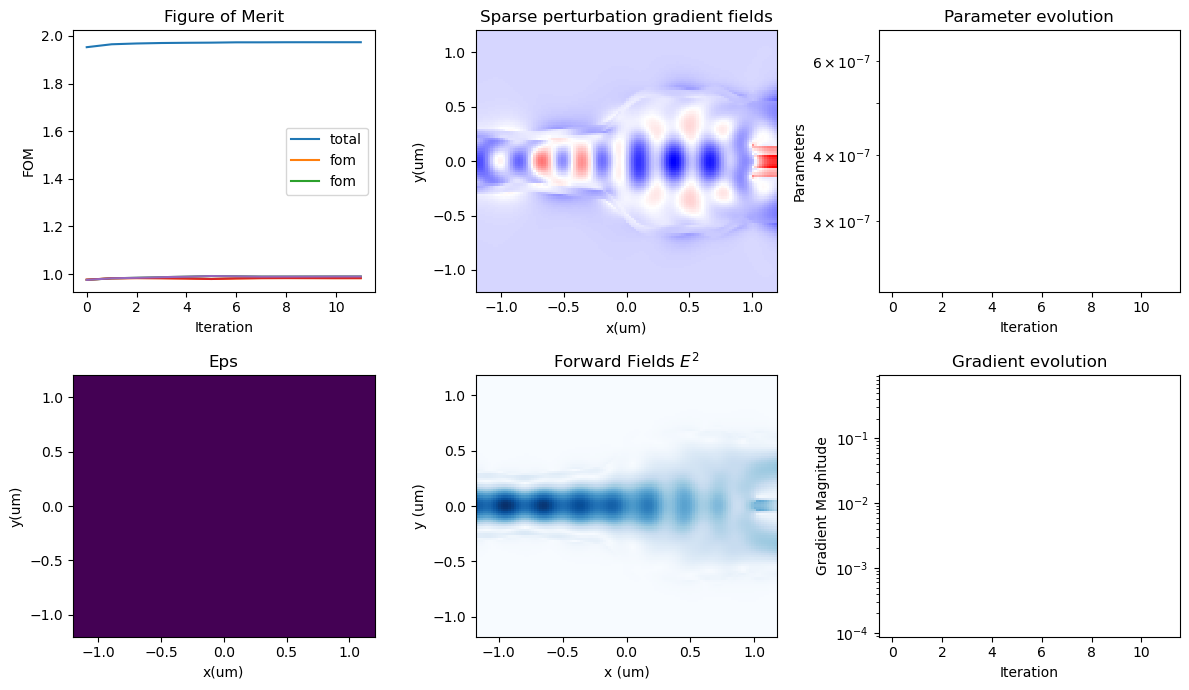

In [36]:
opt.run(working_dir=f'{Config.RESULTS_PATH}/opts')

In [37]:
init_par = [2.33744393e-07, 2.38654336e-07, 2.56414771e-07, 2.70986196e-07,
 2.88235245e-07, 3.23930571e-07, 5.08538970e-07, 6.27999958e-07,
 6.27298974e-07, 6.25365383e-07, 6.19235963e-07, 6.49932940e-07, 5.69475780e-07]

In [38]:
init_par = np.array(init_par)

In [49]:
init_par2 = init_par - 20e-9

In [50]:
ybr, base_script = ybranch_3D(mesh = 3, num_params = 13, init_params=init_par2, poly_wg = True, lithography_model='DUV')

opt = optimizer3D(ybr, base_script)

Accurate interface detection enabled


In [140]:
def robust_opt(num_params, dy):
    '''Creates a splitter polygon using cubic spline interpolation.'''

    eps_in = Material(name = 'Si: non-dispersive')
    eps_out = Material(name = 'SiO2: non-dispersive')

    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, num_params)
    initial_points_y = np.linspace(0.25e-6, 0.6e-6, num_params)

    initial_params_y = normal_params
    bounds = [(0.1e-6, 0.8e-6)] * initial_params_y.size
    dy = dy

    def splitter(params = initial_params_y):
        params = np.array(params)
        params = params + dy
        points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
        points_y = np.concatenate(([initial_points_y[0] + dy], params, [initial_points_y[-1] + dy]))
        
        polygon_points_x = np.linspace(min(points_x), max(points_x), 100)
        interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
        polygon_points_y = interpolator(polygon_points_x)
        polygon_points_y = np.clip(polygon_points_y, 0.075e-6, 0.8e-6)
        
        polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
        polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
        return polygon_points

    depth = 220.0e-9
    polygon1 = FunctionDefinedPolygon_GL(func = splitter, 
                                    initial_params = initial_params_y,
                                    bounds = bounds,
                                    z = 0.0,
                                    depth = depth,
                                    eps_out = eps_out, eps_in = eps_in, dx = 2e-9)
    
    polygons1 = [polygon1]
    
    
    create_waveguides(dy, polygons1)

    # define figure of merit
    fom1 = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)
    
    optimizer = ScipyOptimizers(max_iter = 25, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    geo1 = Geometry_GL(polygons1, 'add')

    opt1 = OptimizationGL(base_script = base_script, wavelengths = wavelengths, fom = fom1, geometry = geo1, optimizer = optimizer, use_var_fdtd=False, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)
    opt = opt1
    return opt

In [147]:
opt1 = robust_opt(15, 0e-9)

Accurate interface detection enabled


In [148]:
opt1.geometry.lithography_model = LithographyOptimizer(model = 'DUV')

In [ ]:
opt1.initialize()

Wavelength range of source object will be superseded by the global settings.


Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing co

: 

In [93]:
opt1.params_hist[-1]

IndexError: list index out of range

In [99]:
y_range = [-40e-9, -30e-9, -20e-9, -10e-9, 0, 10e-9, 20e-9, 30e-9, 40e-9]

opt.initialize()

normal_fom = []
for a in y_range:
    new_params = init_par + a
    normal_fom.append(opt.run_forward_simulation(new_params))

Wavelength range of source object will be superseded by the global settings.


In [100]:
normal_fom

[0.9844531933711893,
 0.9929406292370792,
 0.9930487681030402,
 0.9919448362711044,
 0.9905420770626018,
 0.9897174034384865,
 0.9880781088376343,
 0.9850606873318494,
 0.9781646192672886]